In [1]:
import os

!mkdir -p /content/data/ASVspoof5

In [2]:
!wget -O /content/data/ASVspoof5/flac_D_aa.tar "https://zenodo.org/records/14498691/files/flac_D_aa.tar?download=1"

--2025-04-05 13:53:51--  https://zenodo.org/records/14498691/files/flac_D_aa.tar?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6647265280 (6.2G) [application/octet-stream]
Saving to: ‘/content/data/ASVspoof5/flac_D_aa.tar’

/content/data/ASVsp 100%[===================>]   6.19G  19.3MB/s    in 8m 19s  

2025-04-05 14:02:10 (12.7 MB/s) - ‘/content/data/ASVspoof5/flac_D_aa.tar’ saved [6647265280/6647265280]



In [4]:
!tar -xf /content/data/ASVspoof5/flac_D_aa.tar -C /content/data/ASVspoof5

In [5]:
# Extract the protocols
!tar -xzf /content/data/ASVspoof5/ASVspoof5_protocols.tar.gz -C /content/data/ASVspoof5

# Download one audio part (flac_D_aa.tar)
!wget -O /content/data/ASVspoof5/flac_D_aa.tar "https://zenodo.org/records/14498691/files/flac_D_aa.tar?download=1"

# Extract the audio part
!tar -xf /content/data/ASVspoof5/flac_D_aa.tar -C /content/data/ASVspoof5

# Verify the contents
!ls /content/data/ASVspoof5

tar (child): /content/data/ASVspoof5/ASVspoof5_protocols.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
--2025-04-05 14:11:21--  https://zenodo.org/records/14498691/files/flac_D_aa.tar?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6647265280 (6.2G) [application/octet-stream]
Saving to: ‘/content/data/ASVspoof5/flac_D_aa.tar’

/content/data/ASVsp 100%[===================>]   6.19G  19.9MB/s    in 5m 31s  

2025-04-05 14:16:53 (19.1 MB/s) - ‘/content/data/ASVspoof5/flac_D_aa.tar’ saved [6647265280/6647265280]

flac_D	flac_D_aa.tar


In [6]:
import pandas as pd
import glob

# Find FLAC files
audio_files = glob.glob('/content/data/ASVspoof5/flac_D/*.flac')
num_files = len(audio_files)
print(f"Found {num_files} FLAC files")


if num_files > 0:
    mid_point = num_files // 2
    metadata = pd.DataFrame({
        'speaker_id': ['S{:03d}'.format(i % 50) for i in range(num_files)],
        'audio_file': [os.path.basename(f).replace('.flac', '') for f in audio_files],
        'system_id': ['A01' if i < mid_point else 'A02' for i in range(num_files)],
        'key': ['bonafide' if i < mid_point else 'spoof' for i in range(num_files)]
    })
    metadata.to_csv('/content/data/ASVspoof5/metadata.txt', sep=' ', index=False, header=False)
else:
    raise ValueError("No FLAC files found")

Found 47400 FLAC files


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import librosa
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
import random


In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss


In [9]:
class ASVspoofDataset(Dataset):
    def __init__(self, metadata_file, audio_dir, sr=16000, n_mels=128, duration=2, augment=False):
        self.metadata = pd.read_csv(metadata_file, delim_whitespace=True, header=None)
        self.metadata.columns = ['speaker_id', 'audio_file', 'system_id', 'key']
        self.audio_dir = audio_dir
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.augment = augment

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        audio_file = os.path.join(self.audio_dir, self.metadata.iloc[idx, 1] + '.flac')
        label = 1 if self.metadata.iloc[idx, 3] == 'bonafide' else 0

        audio, _ = librosa.load(audio_file, sr=self.sr)
        expected_length = self.sr * self.duration

        # Data augmentation: random time shift
        if self.augment:
            shift = random.randint(-int(0.1 * self.sr), int(0.1 * self.sr))
            audio = np.roll(audio, shift)
            # adding noise:
            noise = np.random.normal(0, 0.005, audio.shape)
            audio = audio + noise

        # Pad or truncate
        if len(audio) < expected_length:
            audio = np.pad(audio, (0, expected_length - len(audio)), mode='constant')
        else:
            audio = audio[:expected_length]

        # Compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=self.n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec = (mel_spec - np.mean(mel_spec)) / (np.std(mel_spec) + 1e-6)
        mel_spec = np.expand_dims(mel_spec, axis=0)
        return torch.tensor(mel_spec, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [10]:
# Improved ResNet-based model without final activation
class ResNetAudioImproved(nn.Module):
    def __init__(self):
        super(ResNetAudioImproved, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
metadata_file = '/content/data/ASVspoof5/metadata.txt'
audio_dir = '/content/data/ASVspoof5/flac_D/'


In [12]:
full_dataset = ASVspoofDataset(metadata_file, audio_dir, augment=True)


# For class balancing, compute weights (assuming binary classes)
labels = [1 if full_dataset.metadata.iloc[i, 3] == 'bonafide' else 0 for i in range(len(full_dataset))]
class_sample_count = np.array([np.sum(np.array(labels)==0), np.sum(np.array(labels)==1)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[int(t)] for t in labels])
samples_weight = torch.from_numpy(samples_weight).float()

<ipython-input-9-7e5c2b9e77fb>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.metadata = pd.read_csv(metadata_file, delim_whitespace=True, header=None)


In [13]:
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [14]:
# Splitting the dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])


In [19]:
from torch.utils.data import random_split

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetAudioImproved().to(device)
criterion = FocalLoss(alpha=1, gamma=2, logits=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # For binary classification
        predicted = (outputs > 0.5).float()
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/10, Loss: 0.1738, Accuracy: 0.5017
Epoch 2/10, Loss: 0.1733, Accuracy: 0.5016
Epoch 3/10, Loss: 0.1733, Accuracy: 0.5016
Epoch 4/10, Loss: 0.1733, Accuracy: 0.5016
Epoch 5/10, Loss: 0.1733, Accuracy: 0.5016
Epoch 6/10, Loss: 0.1733, Accuracy: 0.5016
Epoch 7/10, Loss: 0.1733, Accuracy: 0.5016
Epoch 8/10, Loss: 0.1733, Accuracy: 0.5016
Epoch 9/10, Loss: 0.1733, Accuracy: 0.5016
Epoch 10/10, Loss: 0.1733, Accuracy: 0.5016


In [21]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [22]:
# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs.squeeze() > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [23]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)
cm = confusion_matrix(all_labels, all_preds)

print("=== Model Performance Summary ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")



=== Model Performance Summary ===
Accuracy: 0.5065
Precision: 0.5065
Recall: 1.0000
F1-Score: 0.6725

Confusion Matrix:
[[   0 4678]
 [   0 4802]]
True Negatives (TN): 0
False Positives (FP): 4678
False Negatives (FN): 0
True Positives (TP): 4802


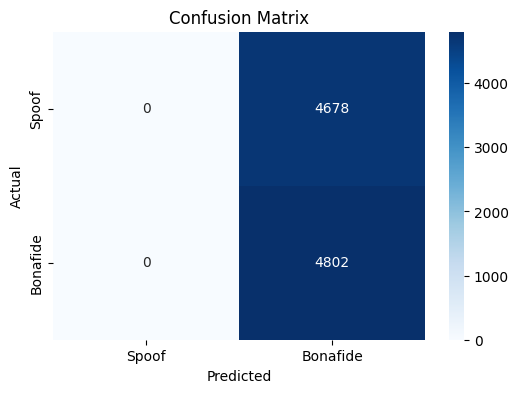

In [24]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Spoof', 'Bonafide'], yticklabels=['Spoof', 'Bonafide'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()